In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os; os.chdir("..")
from melatonin.simulation import car_exhaust


In [2]:
duration = 10
fs = 44_100
N_mics = 8
N_sources = 3

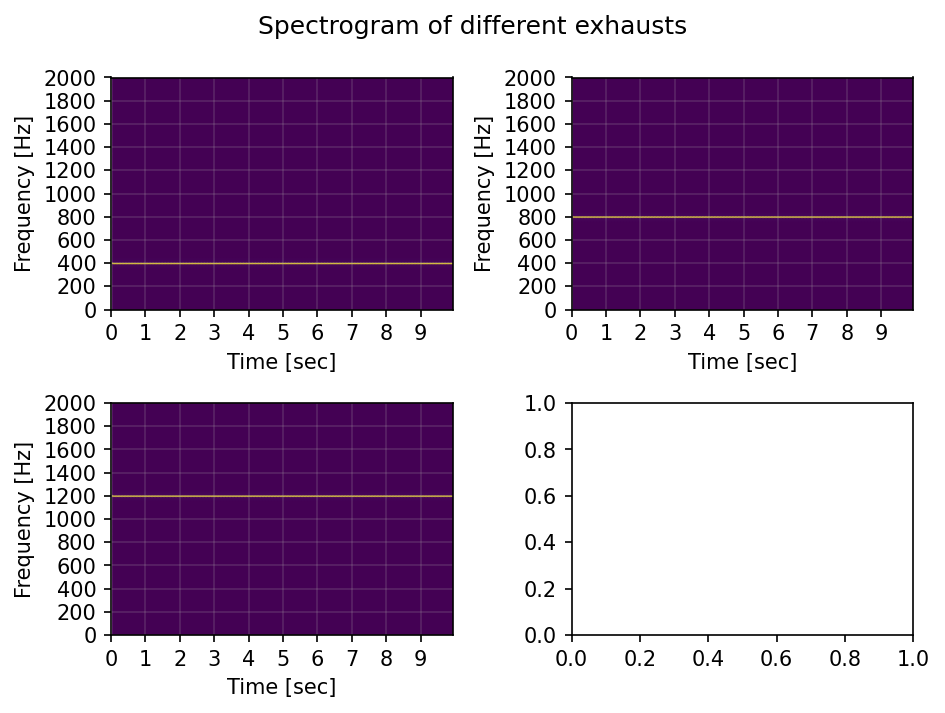

In [3]:
t = np.linspace(0, duration, num=int(fs*duration))
different_exhausts = [
    (np.sin(t*j*400*2*np.pi)).astype(np.float32)
    for j in range(1, N_sources+1)
]
from scipy import signal
fig, axs = plt.subplots(2, 2, dpi=150)
for i, exhaust in enumerate(different_exhausts):
    ax = axs[i//2][i%2]
    f, t, Sxx = signal.spectrogram(exhaust, fs, nperseg=fs//10)
    ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_ylim(0, 2_000)
    ax.set_yticks(np.linspace(0, 2_000, 11))
    ax.set_xticks(np.arange(0, duration))
    ax.grid(alpha=.2)
    #plt.ylim(0, 500)

plt.suptitle("Spectrogram of different exhausts")
plt.tight_layout() 

    

In [18]:
# different_exhausts = [
#     car_exhaust(
#         frequencies = parameters[0],
#         general_modulation=parameters[1],
#         revving_zone=parameters[2],
#         volume=.9,
#         duration=duration
#     )[1]
#     for parameters in [
#         [np.array([20, 100, 60, 200, 30]), 30, [7, 10]],
#         [np.array([30, 70, 40, 300, 25]), 30, [7, 10]],
#         [np.array([40, 90, 50, 100, 45]), 40, [7, 10]],
#         [np.array([35, 110, 40, 250, 55]), 20, [7, 10]],
#     ]
# ]

Text(0.5, 1.0, 'Positions of elements\nthird dimension ignored (for now)')

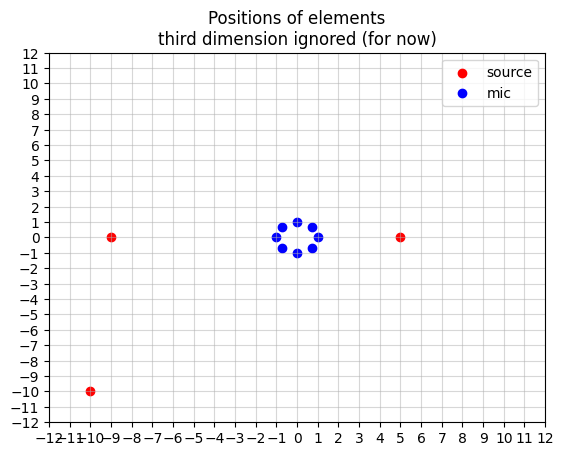

In [4]:


#source_positions = np.random.randn(N_sources, 2)*150
source_positions = np.array([
    [5.0, 0],
    [-10, -10.0],
    [-9.0, 0]
])

angle_rotation = np.pi * 2 / N_mics
rotation_matrix = np.array([
    [np.cos(angle_rotation), -np.sin(angle_rotation)],
    [np.sin(angle_rotation), np.cos(angle_rotation)]
])
mic_positions = []
for i in range(N_mics):
    last_position = mic_positions[-1] if mic_positions else np.array([1, 0])
    mic_positions.append(np.matmul(rotation_matrix, last_position))

mic_positions = np.stack(mic_positions)

plt.scatter(
    source_positions[:, 0],
    source_positions[:, 1],
    label="source",
    color="red",
    marker="o"
)

plt.scatter(
    mic_positions[:, 0],
    mic_positions[:, 1],
    label="mic",
    color="blue",
    marker="o"
)
plt.ylim(-12, 12)
plt.xlim(-12, 12)
plt.xticks(np.linspace(-12, 12, 25))
plt.yticks(np.linspace(-12, 12, 25))
plt.legend()
plt.grid(alpha=.5)
plt.title("Positions of elements\nthird dimension ignored (for now)")

In [5]:
speed_of_sound = 343
def generate_mic_signals(mic_positions, source_positions, different_exhausts, noise=True, verbose=True):
    distances = []
    for mic_i in range(mic_positions.shape[0]):
        distances.append(np.linalg.norm((source_positions - mic_positions[mic_i, :]), axis=1))
    #np.concatenate(distances, axis=1)
    distances = np.array(distances)
    
    time_window = 8
    mic_signals = []

    for mic_i in range(len(mic_positions)):
        mic_signal = None
        for source_j in range(len(source_positions)):
            delay = distances[mic_i, source_j]/speed_of_sound
            start = int(fs * delay)
            stop = min(start + int(fs * time_window), int(different_exhausts[0].shape[0]))
            attenuation = 1/(1+np.log(delay+1)) # TODO: CHECK THIS
            delayed_signal = np.zeros(int(time_window * fs))
            delayed_signal[start:] = attenuation * different_exhausts[source_j][:int(time_window*fs-start)]
            if verbose:
                print(f"Delay for source {source_j} to microphone {mic_i} is {delay:.4f}; attn {attenuation:.2f}")
            if mic_signal is None:
                mic_signal = delayed_signal
            else:
                mic_signal += delayed_signal
        if noise:
            # 0.01 noise amplitude against 0.99 signal is ~40dB SNR
            mic_signal += np.random.randn(int(time_window * fs))*0.01
        mic_signals.append(mic_signal[int(fs*1.1):])
    return mic_signals


Delay for source 0 to microphone 0 is 0.0127; attn 0.99
Delay for source 1 to microphone 0 is 0.0441; attn 0.96
Delay for source 2 to microphone 0 is 0.0284; attn 0.97
Delay for source 0 to microphone 1 is 0.0149; attn 0.99
Delay for source 1 to microphone 1 is 0.0433; attn 0.96
Delay for source 2 to microphone 1 is 0.0264; attn 0.97
Delay for source 0 to microphone 2 is 0.0168; attn 0.98
Delay for source 1 to microphone 2 is 0.0413; attn 0.96
Delay for source 2 to microphone 2 is 0.0243; attn 0.98
Delay for source 0 to microphone 3 is 0.0175; attn 0.98
Delay for source 1 to microphone 3 is 0.0392; attn 0.96
Delay for source 2 to microphone 3 is 0.0233; attn 0.98
Delay for source 0 to microphone 4 is 0.0168; attn 0.98
Delay for source 1 to microphone 4 is 0.0383; attn 0.96
Delay for source 2 to microphone 4 is 0.0243; attn 0.98
Delay for source 0 to microphone 5 is 0.0149; attn 0.99
Delay for source 1 to microphone 5 is 0.0392; attn 0.96
Delay for source 2 to microphone 5 is 0.0264; at

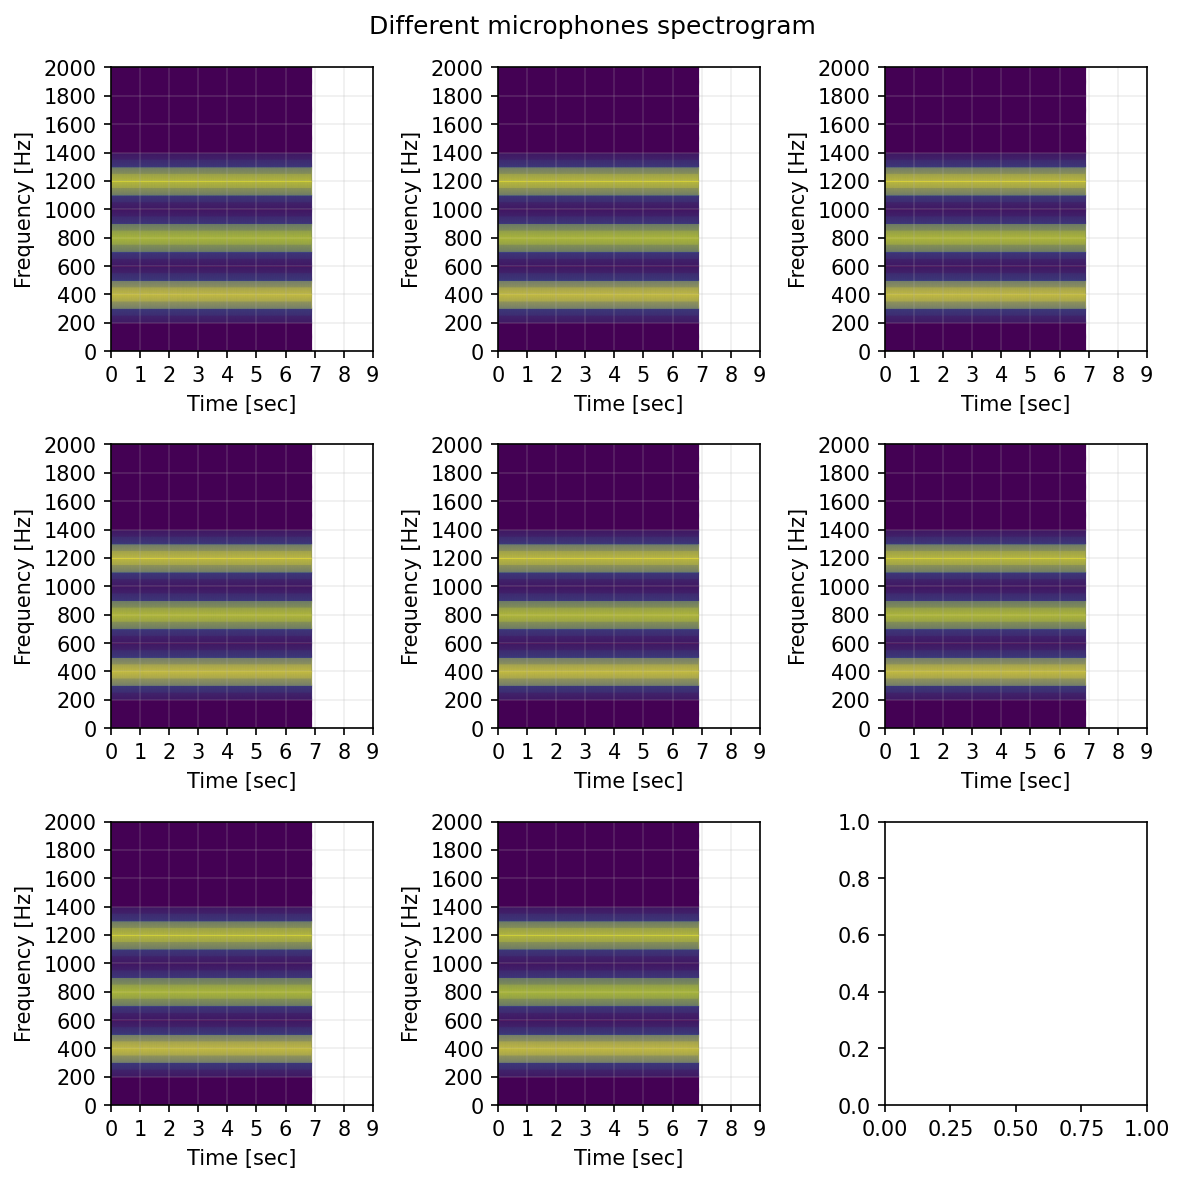

In [6]:

mic_signals = generate_mic_signals(mic_positions, source_positions, different_exhausts)
fig, axs = plt.subplots(N_mics//3+1, 3, dpi=150, figsize=(8, 8))
for i, exhaust in enumerate(mic_signals):
    ax = axs[i//3][i%3]
    f, t, Sxx = signal.spectrogram(exhaust, fs, window=('tukey', 10), noverlap=0, nperseg=fs//100)
    ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_ylim(0, 2_000)
    ax.set_yticks(np.linspace(0, 2_000, 11))
    ax.set_xticks(np.arange(0, duration))
    ax.grid(alpha=.2)
    #plt.ylim(0, 500)

plt.suptitle("Different microphones spectrogram")
plt.tight_layout() 

    

In [9]:
import logging
logging.basicConfig(
    level="ERROR"
)

In [10]:
import melatonin.detector as detector 
from importlib import reload 
reload(detector)
params = detector.Parameters(
    slice_size=2048,
    sampling_frequency=44100,
    microphone_positions=mic_positions,
    #adjacent_zone=16,
    adjacent_zone=2,
    #single_source_threshold=0.87,
    single_source_threshold=0.87,
    speed_of_sound=speed_of_sound,
    estimations_per_zone=4,
    histogram_bins=50,
    Q0=5,
    max_sources=N_sources,
    verbose=True
)
camera = detector.Detector(params, mic_signals)
camera.detect(1, 8)

In [51]:
len(camera.mic_fft_slices[1])

296

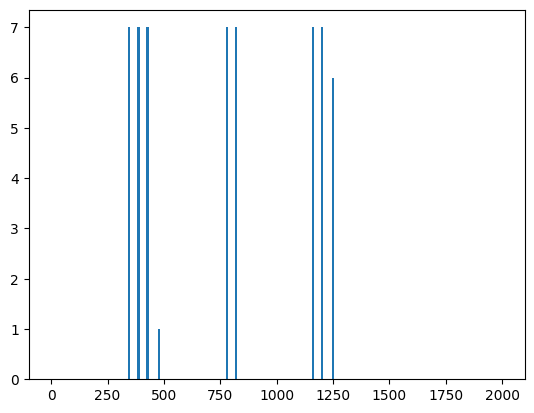

In [52]:
plt.hist(camera.frequencies_of_interest, bins=np.linspace(0, 2000, 200))
None

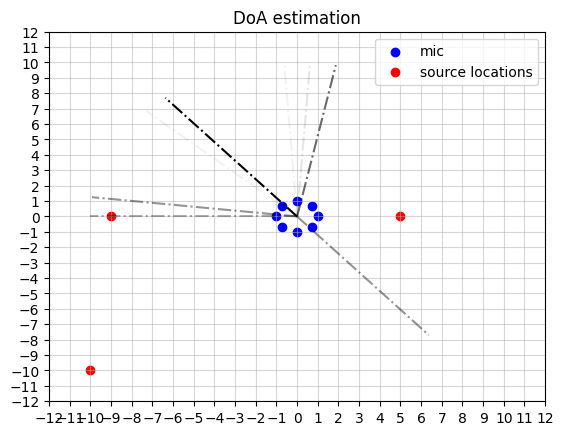

In [53]:
camera.scatter_doa_estimation()
plt.scatter(source_positions[:, 0], source_positions[:,1], label="source locations", color="red")
plt.legend()

TODO: convolve with a filter to get a smoother histogram

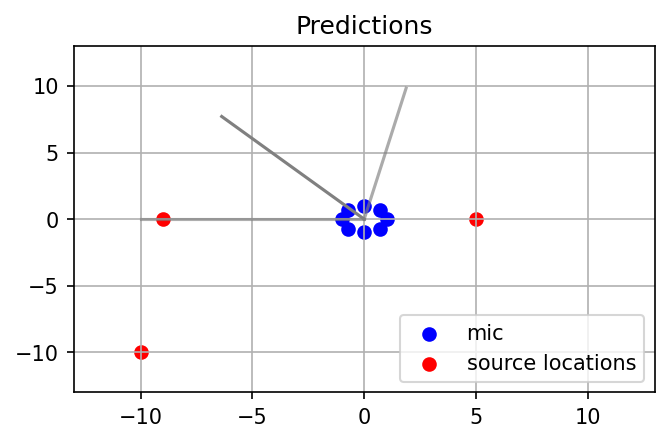

In [54]:
camera.plot_predictions()
plt.scatter(source_positions[:, 0], source_positions[:,1], label="source locations", color="red")
normalized_points = source_positions / np.linalg.norm(source_positions, axis=1, keepdims=True)
true_angles = np.rad2deg(np.arctan2(normalized_points[:, 1], normalized_points[:, 0])) % 360
#plt.scatter(normalized_points[:, 0], normalized_points[:, 1], color="pink")
plt.xlim(-13, 13)
plt.ylim(-13, 13)
plt.legend()

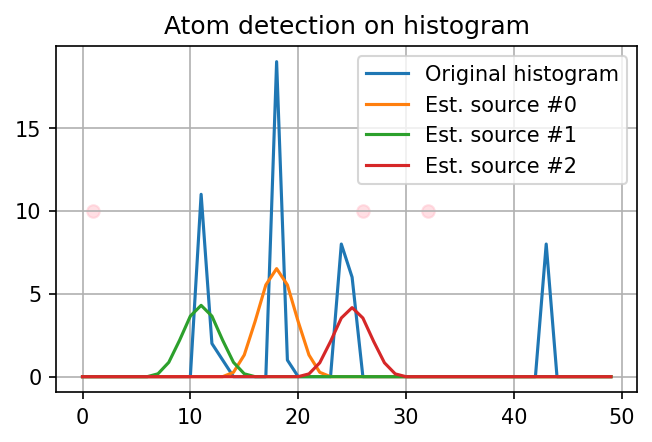

In [55]:
camera.atom_detection_histogram()
true_doa_bins = np.digitize(true_angles, camera.x)

plt.scatter(
    true_doa_bins,
    [10] * len(true_doa_bins),
    color="pink",
    alpha=.5,
)
#plt.legend()

## Inspection

In [ ]:
camera.freq_bins[np.argpartition(camera.mic_fft_slices[0][20], -20)[-20:]]

array([818.26171875, 796.72851562, 775.1953125 , 753.66210938,
       732.12890625, 624.46289062, 538.33007812, 516.796875  ,
       645.99609375, 602.9296875 , 559.86328125, 495.26367188,
       473.73046875, 452.19726562, 667.52929688, 430.6640625 ,
       689.0625    , 710.59570312, 409.13085938, 581.39648438])

In [ ]:
np.mean(np.abs(camera.mic_fft_slices[0][20]))

np.float64(4.7017801193299045)

In [ ]:
len(camera.mic_time_slices)

8

<module 'matplotlib.pyplot' from '/home/joaquintz/res/thebird/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

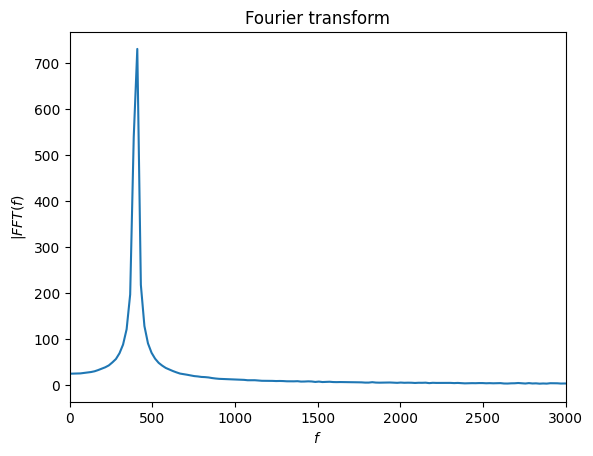

In [ ]:
plt.title("Fourier transform")
#camera.mic_fft_slices[0][20]
plt.plot(camera.freq_bins, np.abs(camera.mic_fft_slices[0][20]))
plt.xlim(0, 3000)
#plt.ylim(0, 10)
plt.ylabel("$|FFT(f)$")
plt.xlabel("$f$")
plt

## Error measuring


In [ ]:
test = True

In [11]:

import melatonin.detector as detector 
from importlib import reload 
reload(detector)
import itertools
from tqdm import tqdm

def run_simulations(position_generator, simulations=100, time_window=4, sources=N_sources):
    errors = []
    predictions = []
    grounds = []
    grounds_pos = []
    for _ in tqdm(range(simulations)):
        source_positions = position_generator(sources)

        mic_signals = generate_mic_signals(mic_positions, source_positions, different_exhausts, verbose=False)
        
        params = detector.Parameters(
            slice_size=2048,
            sampling_frequency=44100,
            microphone_positions=mic_positions,
            adjacent_zone=2,
            single_source_threshold=0.7,
            speed_of_sound=speed_of_sound,
            estimations_per_zone=4,
            histogram_bins=50,
            Q0=5,
            max_sources=N_sources,
        )
        camera = detector.Detector(params, mic_signals)
        camera.detect(1, 1+time_window)

        normalized_points = source_positions / np.linalg.norm(source_positions, axis=1, keepdims=True)
        real_doas = np.rad2deg(np.arctan2(normalized_points[:, 1], normalized_points[:, 0])) % 360
        predicted_doas = camera.x[camera.atoms]
        
        # Metric calculation 
        # Since assignment is not direct we find the assignment that gives the lowest rmse and use that.
        if len(predicted_doas) < len(source_positions):
            continue
        
        min_norm = 1e3
        for permutation in list(itertools.permutations(list(range(len(source_positions))))):
            new_norm = np.linalg.norm(real_doas - predicted_doas[list(permutation)])
            #if min_norm > new_norm:
            #    best_permutation = list(permutation)
            min_norm = min(new_norm, min_norm)
            if min_norm == new_norm:
                best_pred = predicted_doas[list(permutation)]
        errors.append(min_norm)
        predictions.append(best_pred)
        grounds.append(real_doas)
        grounds_pos.append(source_positions)
    return {
        "errors": errors, 
        "predictions": predictions, 
        "grounds": grounds, 
        "grounds_pos": grounds_pos,
        "mean_error": np.mean(errors),
        "std_error": np.std(errors)
    }

In [12]:
# Generation strategy

def sources_uniform(num, amplitude=6):
    doas = np.random.random(num)*2*np.pi
    return np.stack([np.cos(doas), np.sin(doas)], axis=1)*amplitude

def fixed_spread(num, spread_deg, amplitude=6):
    # First offset can be at most at the spread angle
    spread_rad = np.deg2rad(spread_deg)
    if spread_rad * num > 2*np.pi:
        raise ValueError(f"{num} * {spread_deg} > 360!!")
    offset = np.random.random()*(2*np.pi - spread_rad*num)
    doas = [offset + i*spread_rad for i in range(num)]
    return np.stack([np.cos(doas), np.sin(doas)], axis=1)*amplitude


100%|██████████| 100/100 [00:11<00:00,  8.65it/s]


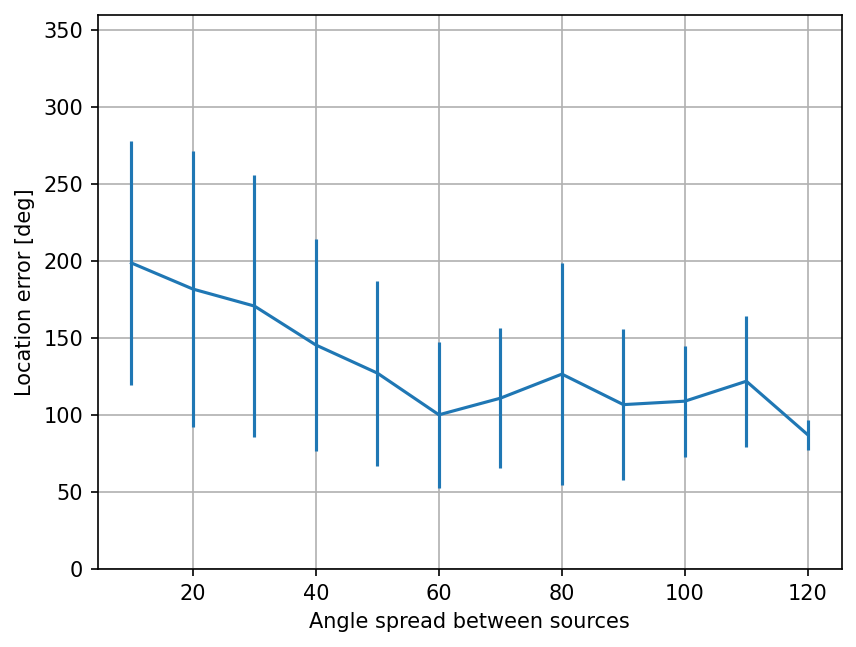

In [13]:
from functools import partial 

results =  []
for spread in np.linspace(10, 120, 12):
    results.append(run_simulations(partial(fixed_spread, spread_deg=spread), simulations=100, time_window=4, sources=N_sources))


plt.figure(dpi=150, facecolor="white")
plt.errorbar(np.linspace(10, 120, 12), [result["mean_error"] for result in results], [result["std_error"] for result in results])
plt.xlabel("Angle spread between sources")
plt.ylabel("Location error [deg]")
plt.ylim(0, 360)
plt.grid()

In [16]:
len(camera.mic_fft_slices[1])

296

100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


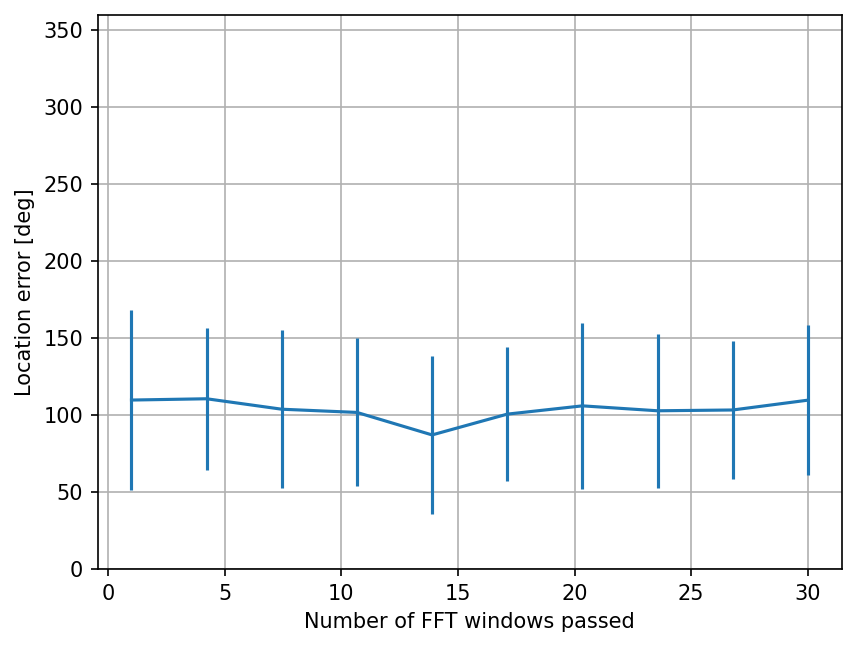

In [18]:
from functools import partial 

results =  []
sweep = np.linspace(1, 30, 10)
for window_size in sweep:
    results.append(run_simulations(partial(fixed_spread, spread_deg=90), simulations=100, time_window=int(window_size), sources=N_sources))

plt.figure(dpi=150, facecolor="white")
plt.errorbar(sweep, [result["mean_error"] for result in results], [result["std_error"] for result in results])
plt.xlabel("Number of FFT windows passed")
plt.ylabel("Location error [deg]")
plt.ylim(0, 360)
plt.grid()

114/71 con el np.A viejo
101/78 con el nuevo?